# Vector database comparison for AI Workloads: Elasticsearch vs. MongoDB Atlas Vector Search

While both MongoDB Atlas and Elasticsearch can store vector embeddings for AI applications, they serve fundamentally different purposes. This notebook explores multiple approaches to implementing vector search, compering their benefits and challenges:

1. **Elasticsearch for Vector Search:**

   Elasticsearch is primarely a search engine optimized for information retriaval and analitics. It efficiently handles vector embeddings to enable semantic search capabilities. In this notebook, we demonstrate how to implement vector search with Elasticsearch, highlighting its search optimizations capabilities

2. **MongoDB Atlas for Unified AI Workloads:**

   MongoDB Atlas is a fully-featured database with built-in vector search capabilities. As a true database, it offers ACID complience - ensuring Automicity, Consistency, Isolation and Durability - which is essential for production AI applicatios that require data reliability. We illustrate how to implement vector search using MongoDB Atlas, showcasting its ability to handle both vector search and traditional database operations within a unified system.

3. **Split Architecture vs. Unified Architecture:**
   - **Split Architecture:** In this approach, vector embeddings are stored in Elasticsearch to leverage its search capabilities, while metadata and other critical information are managed in MongoDB Atlas. This model allows you to utilize the strengths of both systems but produces challenges such as data synchronization and consistency between the two systems.
   - **Unified Architecture:** Alternatively MongoDB Atlas can be used to handle both vector search and data storage in a single system. Thi sunified approach simplifies the architecture by eliminating cross-database synchronization issues, ensuring robust ACID compliance and streamlined operations for AI workloads.

## Table of Contents

- **Part 1. Data Setup** - Installing libraries, setting up connections, preparing the dataset
- **Part 2. Elasticsearch Implementation** - Setting up and using Elasticsearch for vector search
- **Part 3. MongoDB Atlas Implementation** - Setting up and using MongoDB Atlas for vector search
- **Part 4. Split Architecture** - Implementing a hybrid approach (Elastic as vector datbase and MongoDB as operational) with both databases
- **Part 5. Unified Architecture** - Using MongoDB Atlas for both vector search and data storage
- **Part 6. Performance Guidance** - Overview of the benefits of a unified architecture

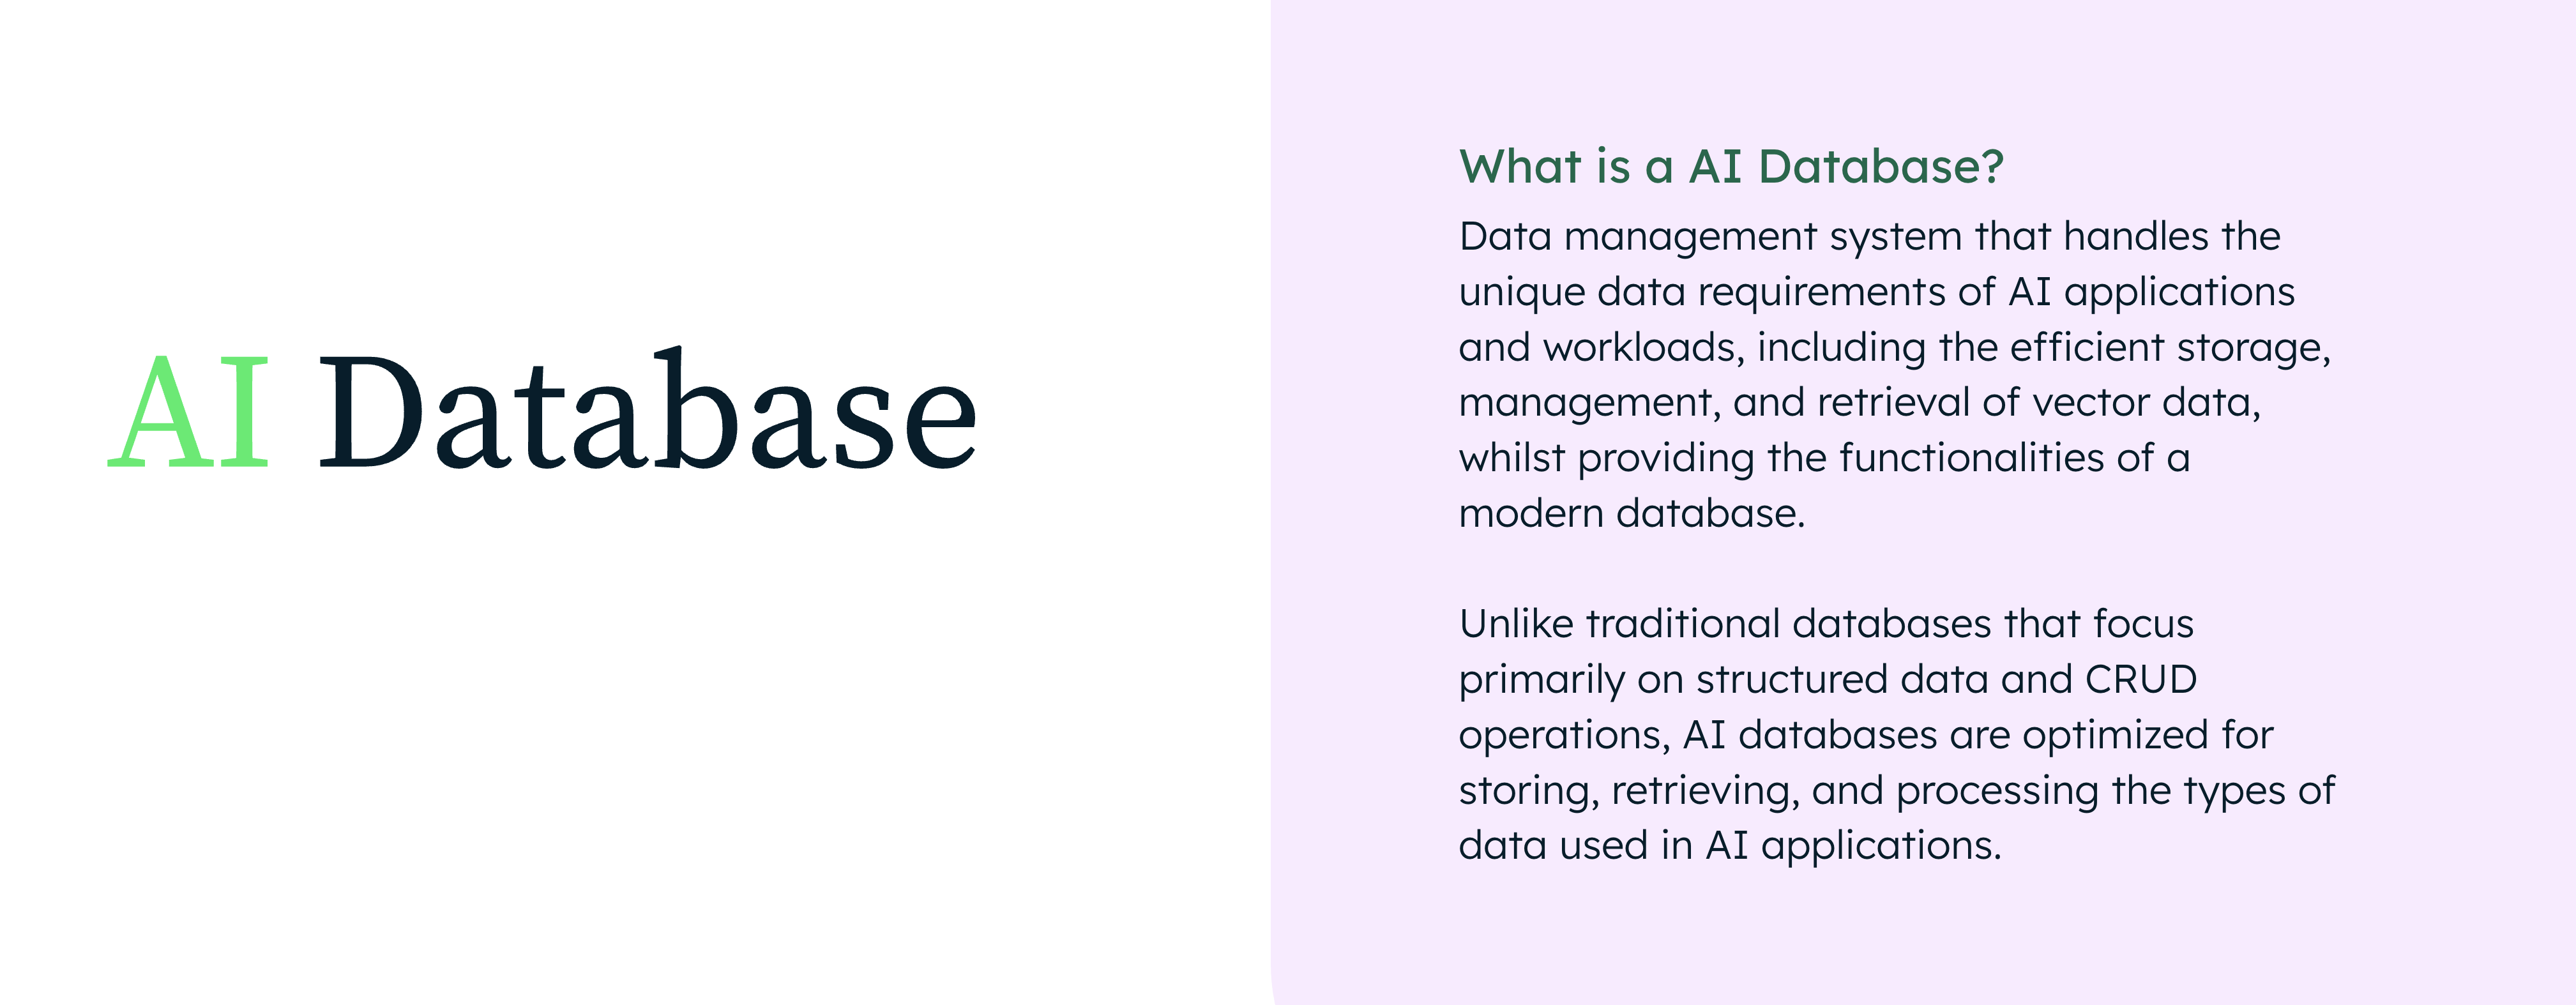

## Part 1: Data Setup

In [1]:
import getpass
import os

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

### Step 1: Install Libraries

All the libraries are installed using `pip` and facilitate the sourcing of data, embedding generation and data visualization.

- `datasets`: Hugging Face library for managing and preprocessing datasets across text, image and audio (https://huggingface.co/datasets)
- `voyageai`: A library for creating sentence embeddings for tasks like semantic search and clustering (https://voyageai.com/)
- `pandas`: A library for data manipulation and analysis with DataFrames and Series (https://pandas.pydata.org/)
- `matplotlib`: A library for creating static, interactive and animated data visualizations (https://matplotlib.org/)

In [3]:
%pip install --upgrade datasets voyageai pandas matplotlib

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.0 MB 8.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 8.4 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/11.0 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 6.7 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.1 MB 6.6 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 6.5 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 6.7 MB/s eta 0:00:01
   -------------

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart kernel to use updated packages

### Step 2: Data Loading

In [4]:
# Import necessary libraries
# data sets is a Hugging Face library for accessing and working with datasets
# pandas is used for data manipulation and analysis
import pandas as pd
from datasets import load_dataset

c:\Users\yulic\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
wikipedia_data_amount = 1000

In [6]:
# Load the wikipedia annotation data
wikipedia_data = load_dataset(
    "MongoDB/wikipedia-22-12-en-voyage-embed", streaming=True, split="train"
)

In [7]:
wikipedia_data_head = wikipedia_data.take(wikipedia_data_amount)
wikipedia_data_df = pd.DataFrame(wikipedia_data_head)

In [9]:
# Drop the _id, wiki_id, views, paragraph_id, section_id and langs columns
# These columns are not needed for the vector search
wikipedia_data_df = wikipedia_data_df.drop(
    columns=["_id", "id", "wiki_id", "views", "paragraph_id", "langs"]
)

# Convert the text embedding to a list of floats from a string
wikipedia_data_df["embedding"] = wikipedia_data_df["embedding"].apply(lambda x: eval(x))

wikipedia_data_df.head()

,title,text,url,embedding
0,YouTube,YouTube is a global online video sharing and s...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.0270681083202362, 0.0237626451998949, -0.0..."
1,YouTube,"In October 2006, YouTube was bought by Google ...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.0442084409296512, 0.0446286313235759, -0.0..."
2,YouTube,"Since its purchase by Google, YouTube has expa...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.0241227727383375, 0.0164146348834037, -0.0..."
3,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.0028252257034182, 0.0495448783040046, 0.00..."
4,YouTube,"YouTube was founded by Steve Chen, Chad Hurley...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.0574200861155986, 0.0406263954937458, -0.0..."


### Step 3: Embedding Generation

In [ ]:
# Set Cohere API key
set_env_securely("VOYAGE_API_KEY", "Enter your Voyage API key: ")

In [ ]:
import voyageai

# Initialize the voyage AI client
voyage_ai_client = voyageai.Client()


def get_embedding(text, task_prefix="document"):
    """
    Generate embeddings for a text string with a task-specific prefix using the voyage-3-large model.

    Parameters:
        text (str): The input text to be embedded.
        task_prefix (str): A prefix describing the task; this is prepended to the text.

    Returns:
        list: The embedding vector as a list of floats (or ints if another output_dtype is chosen). 
    """
    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []
    
    # Call the Voyage API to generate the embedding.
    # Here, we wrap the text in a list since the API expects a list of texts.
    # Default output embedding: 1024
    result = voyage_ai_client.embed(
        [text], model="voyage-3-large", input_type=task_prefix
    )

    # Return the first embedding from the result.
    return result.embeddings[0]

Generate embeddings for thequery templates used in benchmarking process

Note: Doing this to avoid the overhead of generating embeddings for each query during the benchmark process

Note: Feel free to add more queries to the `query_templates` list to test the performance of the vector database with a larger number of queries

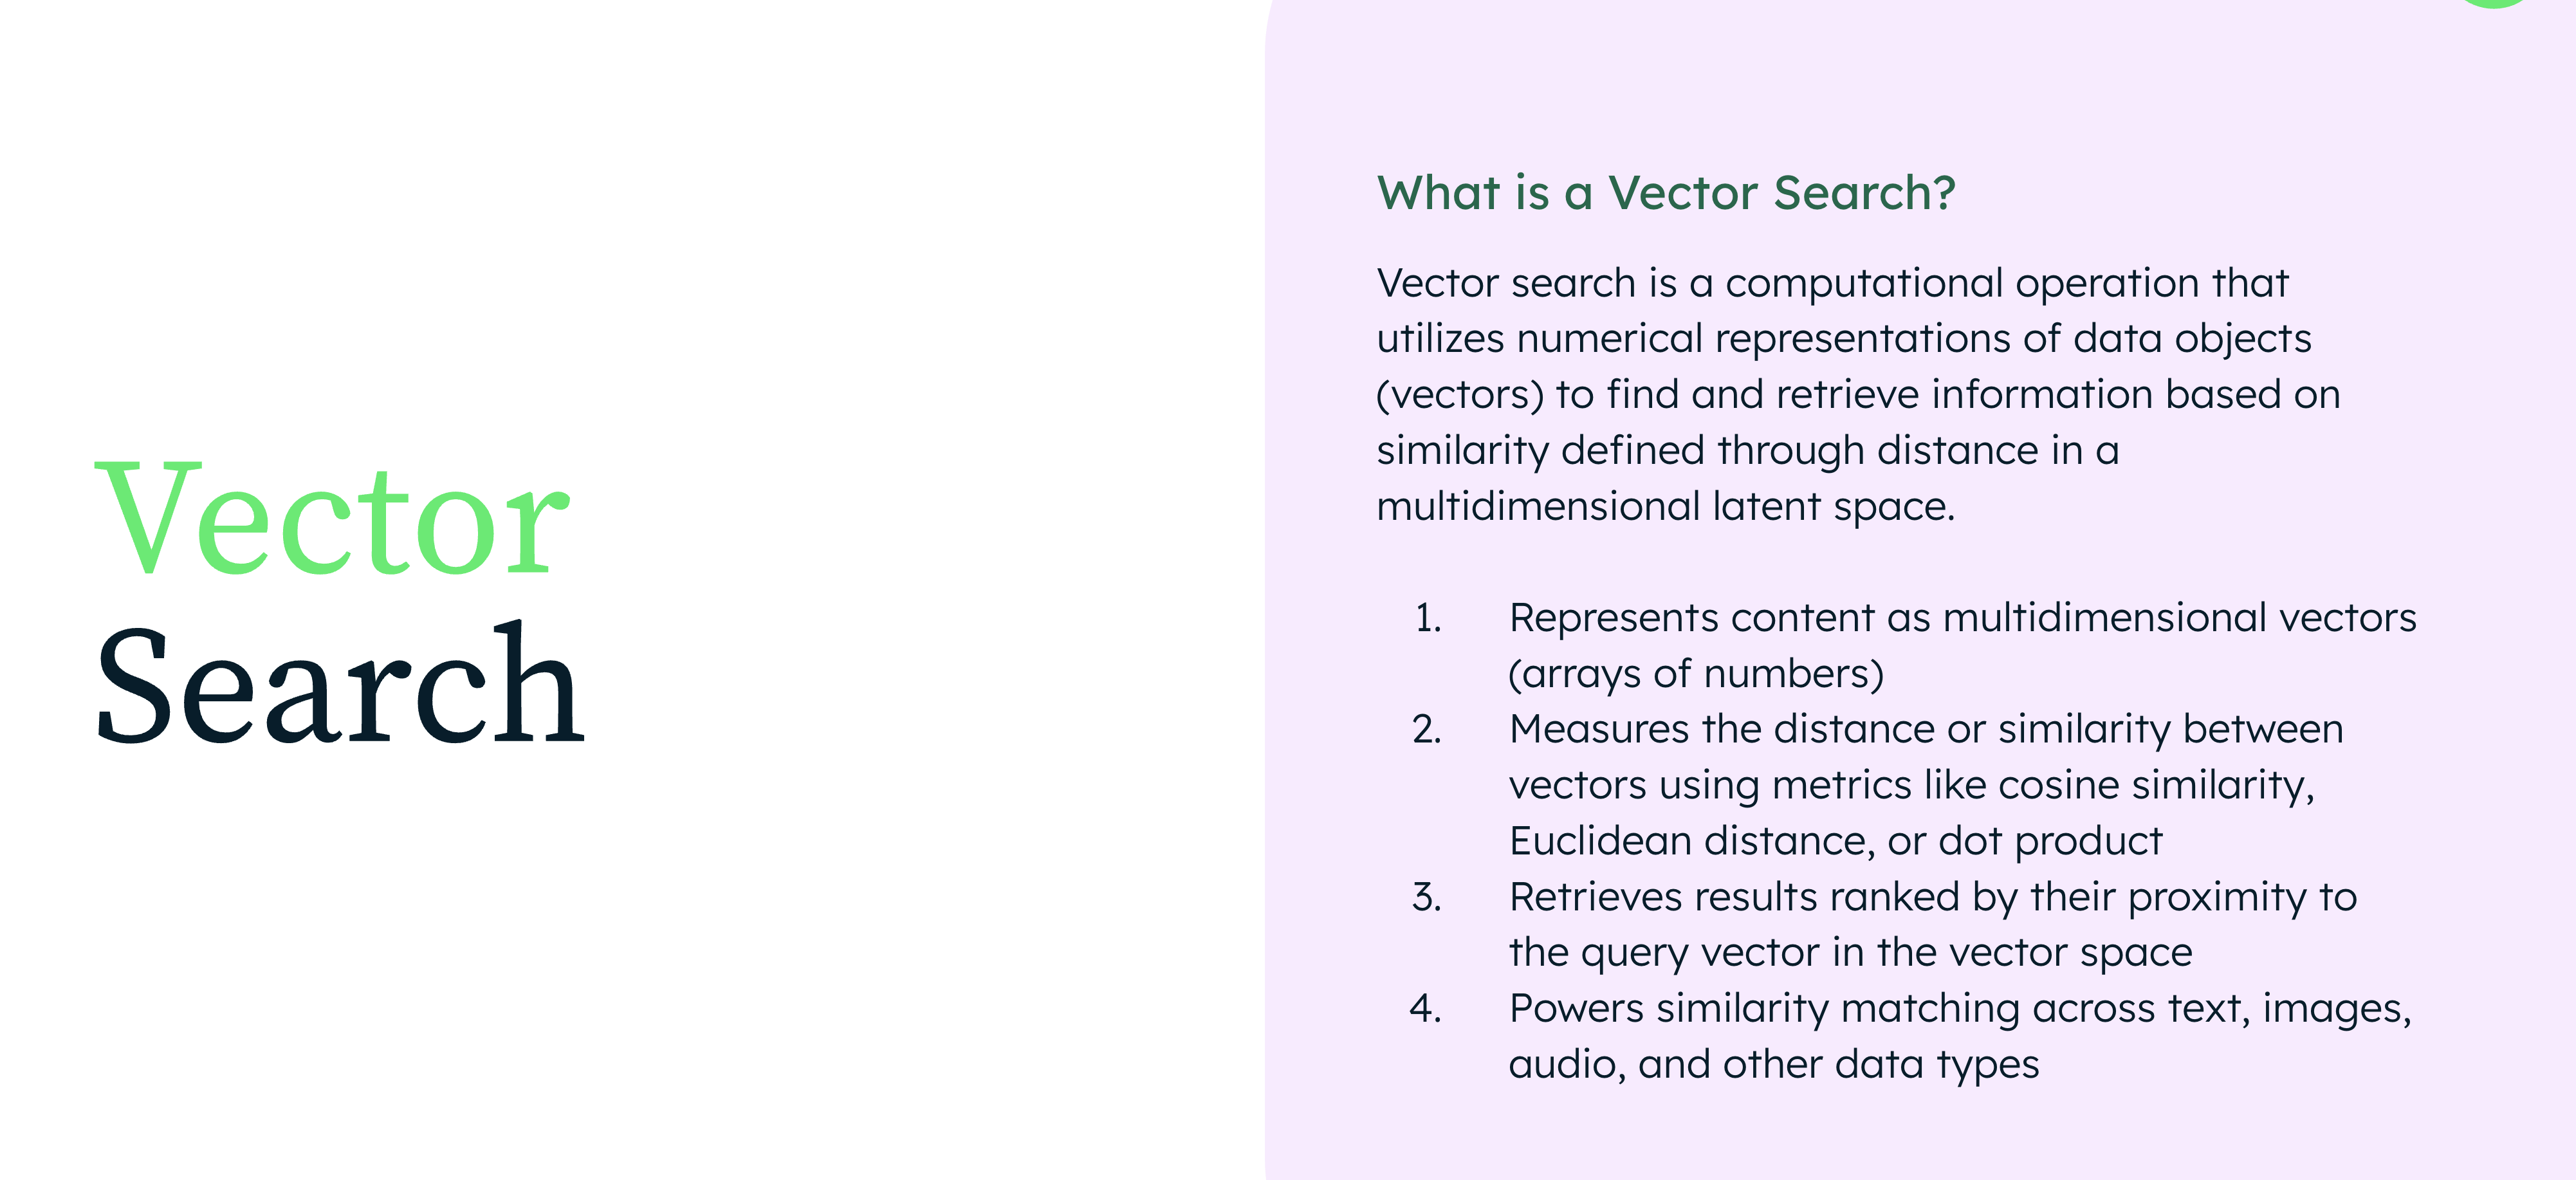

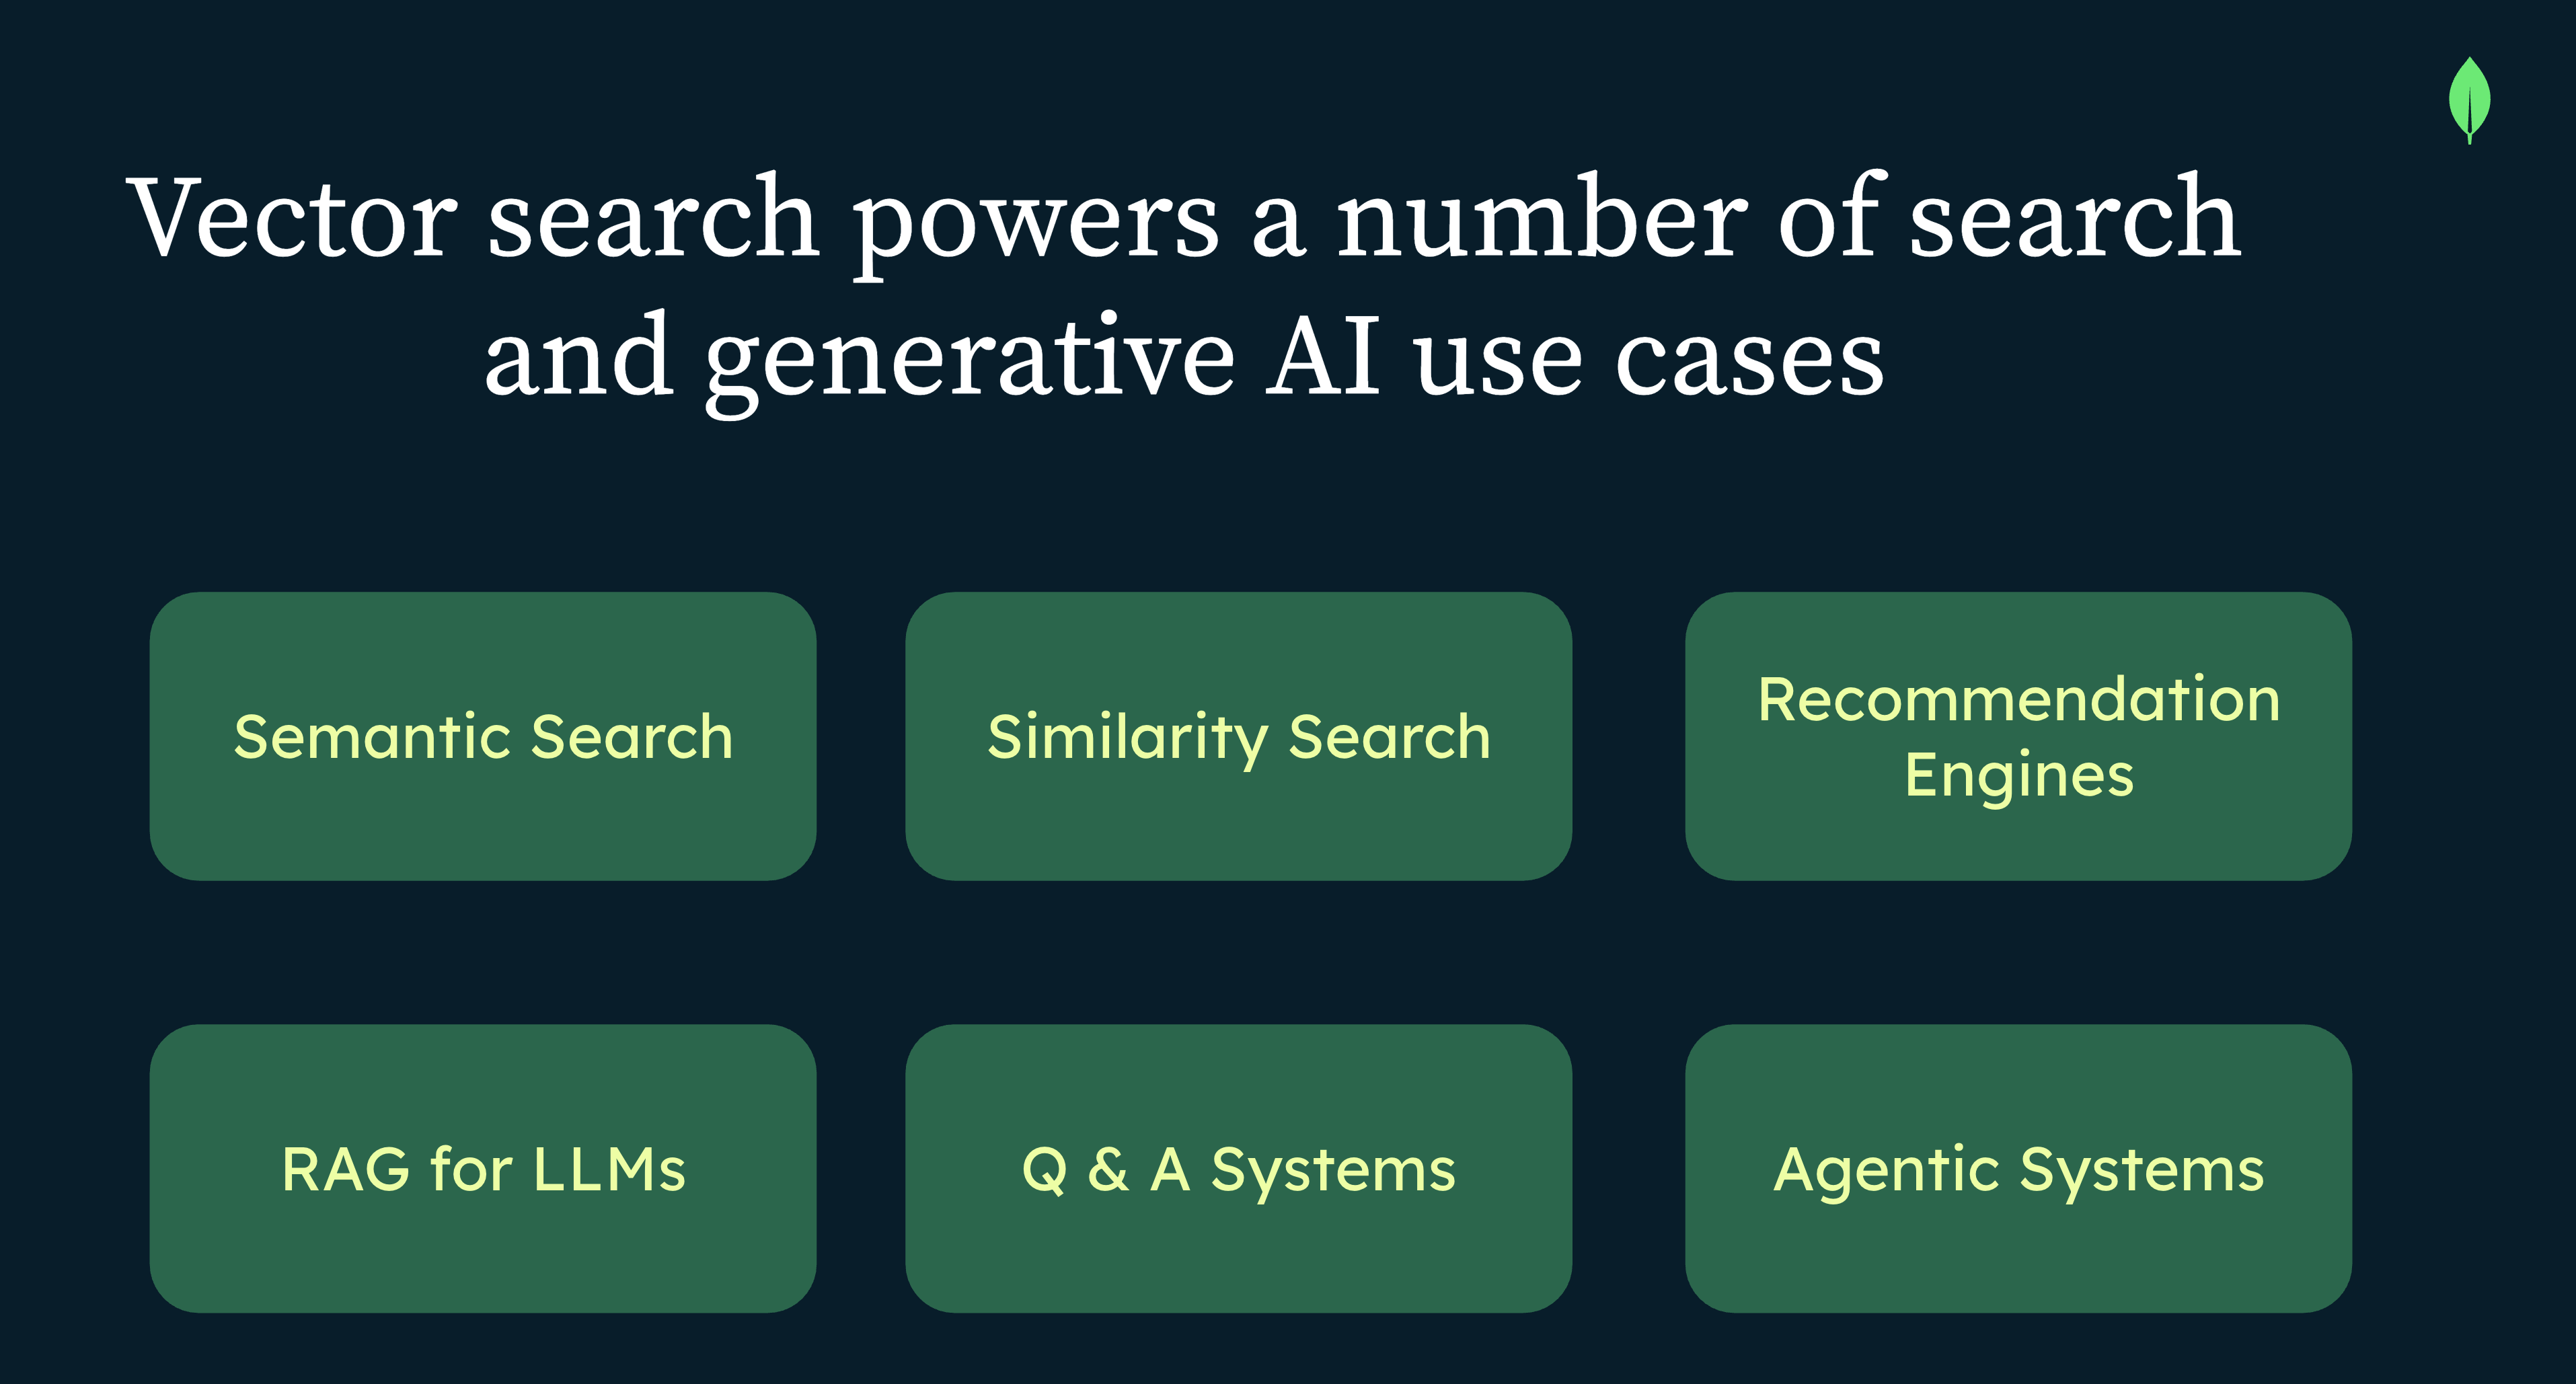

## Part 2: Vector Search with Elasticsearch

### Step 1: Install Libraries

In [ ]:
%pip install --upgrade elasticsearch eland

Note: you may need to restart the kernel to use updated packages.

### Step 2: Installing Elasticsearch Locally

**Run start-local**

To set up Elasticsearch and Kibana locally, run the start-local script:

```curl -fsSL https://elastic.co/start-local | sh```

This script creates an elastic-start-local folder containing configuration files and starts both Elasticsearch and Kibana using Docker.

After running the script, you can access Elastic services at the following endpoints:

- Elasticsearch: http://localhost:9200
- Kibana: http://localhost:5601

Elasticsearch is installed using docker.

Find more on installing Elasticsearch with docker [here](https://www.elastic.co/guide/en/elasticsearch/reference/current/run-elasticsearch-locally.html)

The Elasticsearch docker image is pulled from the [elasticsearch](https://hub.docker.com/_/elasticsearch) repository.

NOTE: To uninstall Elasticsearch, run the following command:

```./uninstall.sh```

Your Elastic Cloud API Key will be shown on the terminal after running the start-local script

In [ ]:
set_env_securely("ELASTIC_API_KEY", "Enter your Elastic API key: ")

In [ ]:
from elasticsearch import Elasticsearch, helpers

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = os.environ["ELASTIC_API_KEY"]

# Create the client instance
es_client = Elasticsearch(
    # For local development
    hosts=["http://localhost:9200"],
    # cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
)

# Confirm the client has connected
print(es_client.info())

### Step 3: Create Elasticsearch Index

Create an index with the name `wikipedia_data` and the following mapping:
- `title`: The title of the Wikipedia article
- `text`: The text of the Wikipedia article
- `url`: The URL of the Wikipedia article
- `embedding`: The embedding vector for the Wikipedia article

Create an index in Elasticsearch with the right index mapping to handle vector searches.

One thing to note is that by default Elasticsearch quantizes the embeddings to 8 bits. This means that the precision of your vector embeddings are reduced if you don't explicitly set the index_options to hnsw. More info can be found in the Elasticsearch documentation.

In [ ]:
es_index_name = "wikipedia_data"

# Using an explicit mapping to handle various search patterns
index_mapping = {
    "properties": {
        "title": {"type": "text"},
        "text": {"type": "text"},
        "url": {"type": "text"},
        "embedding": {
            "type": "dense_vector",
            "dims": 1024,
            "index": "true",
            "similarity": "cosine",
            "index_options": {
                "type": "hnsw" # Setting the index type to hnsw to override the default 8 bit quantization
            }
        }
    }
}

# flag to check if index has to be deleted before creating
should_delete_index = True

# check if we want to delete index before creating the index
if should_delete_index:
    if es_client.indices.exists(index=es_index_name):
        print(f"Deleting existing {es_index_name}")
        es_client.indices.delete(index=es_index_name, ignore=[400, 404])

print(f"Creating index {es_index_name}")

index_settings = {}

# Create the index
es_client.options(ignore_status=[400, 404]).indices.create(
    index=es_index_name, mappings=index_mapping, settings=index_settings
)

### Step 4: Define insert function

In [ ]:
from elasticsearch.helpers import BulkIndexError

# Define the function to batch the data to bulk actions
def batch_to_bulk_actions(batch, index_name):
    for _, record in batch.iterrows():
        action = {
            "_index": index_name,
            "_source": {
                "title": record["title"],
                "text": record["text"],
                "url": record["url"],
                "embedding": record["embedding"],
            },
        }
        yield action

def insert_data_to_elastic(dataframe, client, index_name):
    """
    Insert data into Elasticsearch and record benchmark metrics.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the data to insert.
        client (elasticsearch.Elasticsearch): The Elasticsearch client to use for the insertion.
        index_name (str): The name of the index to insert into.
    """
    print("Inserting data into Elasticsearch")

    try:
        # Convert DataFrame records to Elasticsearch actions
        actions = list(batch_to_bulk_actions(dataframe, index_name))

        print("Performing bulk insert")
        # Perform bulk insert
        success, failed = helpers.bulk(client, actions, stats_only=True)

        print(f"Bulk insert completed: {success} documents inserted, {failed} failed")

        return True
    
    except BulkIndexError as e:
        print(f"Error during bulk insert: {e.errors}")
        return False
    except Exception as e:
        print(f"Error during data ingestion: {e}")
        return False

### Step 5: Insert Data into Elastic

In [ ]:
try:
    insert_data_to_elastic(wikipedia_data_df, es_client, es_index_name):
    print("Data ingestion into Elasticsearch complete!")
except BulkIndexError as e:
    print(f"{e.errors}")
except Exception as e:
    print(f"Error during data ingestion: {e}")

### Step 6: Define Full Text Search function

In [ ]:
def full_text_search_with_elastic(query, client, top_n=5):
    search_body = {"query": {"match": {"text": query}}}

    response = client.seaarch(
        index=es_index_name,
        body=search_body,
        size=top_n,
        _source_excludes=["embedding", "id"], # Exclude unwanted fields
    )

    results = []
    for hit in response["hits"]["hits"]:
        score = hit["_score"]
        title = hit["_source"]["title"]
        text = hit["_source"]["text"]
        url = hit["_source"]["url"]
        result = {"_score": score, "title": title, "text": text, "url": url}
        results.append(result)
    return results

In [ ]:
query_text = "When was YouTube officially launched, and by whom?"

get_knowledge_full_text = full_text_search_with_elastic(query_text, es_client, top_n=5)

In [ ]:
pd.DataFrame(get_knowledge_full_text).head()

### Step 7: Define semantic search function

In [ ]:
def semantic_search_with_elastic(plot_query, client, index_name, top_n=5):
    query_embedding = get_embedding(plot_query, "query")

    knn = {
        "field": "embedding",
        "query_vector": query_embedding,
        "k": top_n,
        "num_candidates": 100,
    }
    response = client.search(
        index=index_name,
        knn=knn,
        size=top_n,
        _source_excludes=[
            "embedding",
            "id",
        ], # Exclude the embedding field from the results
    )
    results = []
    for hit in response["hits"]["hits"]:
        score = hit["_score"]
        title = hit["_source"]["title"]
        text = hit["_source"]["text"]
        url = hit["_source"]["url"]
        result = {"_score": score, "title": title, "text": text, "url": url}
        results.append(result)
    return results


In [ ]:
query_text = "When was YouTube officially launched, and by whom?"

get_knowledge_semantic = semantic_search_with_elastic(
    query_text, es_client, es_index_name, top_n=5
)

In [ ]:
pd.DataFrame(get_knowledge_semantic).head()

## Part 3: Search with MongoDB Atlas Vector Search

### Step 1: Install Libraries

- `pymongo` (4.10.1): A Python driver for MongoDB
(https://pymongo.readthedocs.io/en/stable/)

In [ ]:
%pip install --upgrade pymongo pandas

### Step 2: Installing MongoDB via Atlas CLI

The Atlas CLI is a command line interface built specifically for MongoDB Atlas. Interact with your Atlas database deployments and Atlas Search from the terminal with short, intuitive commands, so you can accomplish complex database management tasks in seconds.

You can follow the instractions [here](https://www.mongodb.com/docs/atlas/cli/current/install-atlas-cli/#complete-the-prerequisites-3) to install the Atlas CLI using Docker (other options are available) and get a local MongoDB database instance running.

Follow the steps [here](https://www.mongodb.com/docs/atlas/cli/current/atlas-cli-docker/#follow-these-steps) to run Atlas CLI commands with Docker.

Find more information on the Atlas CLI [here](https://www.mongodb.com/docs/atlas/cli/):

### Step 3: Connect to MongoDB and Create Database and Collection

After installing the Atlas CLI, you can run the following command to connect to your MongoDB database:

1. `atlas deployments connect`
2. You will be prompted to specify "How would you like to connect to local9410"
3. Select connectionString
4. Copy the connection string and paste it into the MONGO_URI environment variable

More information [here](https://www.mongodb.com/docs/atlas/cli/current/atlas-cli-deploy-fts/#connect-to-the-deployment)

In [ ]:
# Set MongoDB URI
# Example: mongodb://localhost:52094/?directConnection=true
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")

In the following code blocks below we do the following:
1. Establish a connection to the MongoDB database
2. Create a database and collection if they do not already exist
3. Delete all data in the collection if it already exists

In [ ]:
import pymongo

def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.mongodb_vs_elasticsearch.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None

MONGO_URI = os.environ["MONGO_URI"]
if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

In [ ]:
from pymongo.errors import ColelctionInvalid

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "vector_db_demo"
COLLECTION_NAME = "wikipedia_data_test"

# Create or get the database
db = mongo_client[DB_NAME]

# Check if the collection exists
if COLLECTION_NAME not in db.list_collection_names():
    try:
        # Create the collection
        db.create_collection(COLLECTION_NAME)
        print(f"Collection '{COLLECTION_NAME}' created successfully.")
    except ColelctionInvalid as e:
        print(f"Error creating collection: {e}")
else:
    print(f"Collection '{COLLECTION_NAME}' already exists.")

# Assign the collection
collection = db[COLLECTION_NAME]

In [ ]:
collection.delete_many({})

### Step 4: Vector Index Creation

The `setup_vector_search_index` function creates a vector search index for the MongoDB collection.

The `index_name` parameter is the name of the index to create.

The `embedding_field_name` parameter is the name of the field containing the text embeddings on each document within the wikipedia_data collection.

In [ ]:
embedding_field_name = "embedding"
vector_search_index_name = "vector index"

In [ ]:
from pymongo.oprations import SearchIndexModel


def setup_vector_search_index(collection, index_name="vector_index"):
    """
    Setup a vector search index for MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing an index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition={
            "fields": [
                {
                    "type": "vector",
                    "path": "embedding",
                    "numDimentions": 1024,
                    "similarity": "cosine",
                },
                {
                    "type": "filter",
                    "path": "title",
                },
            ]
        },
        name=index_name,
        type="vectorSearch",
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")
        return result
    
    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

In [ ]:
setup_vector_search_index(collection, vector_search_index_name)

### Step 5: Create Search Index

In [ ]:
def setup_text_search_index(collection, index_name="text_search_index"):
    """ 
    Setup a text search index for a MongoDB collection in Atlas.
    
    Args:
        collection (Collection): MongoDB collection object.
        index_name (str): Name of the index (default: "text_search_index"). 
    """
    # Define the search index model
    search_index_model = {
        "name": index_name,
        "type": "search",
        "definition": {
            "mappings": {
                "dynamic": False, # Disable automatic detection; only explicitly defined fields are indexed
                "fields": {"title": {"type": "string"}},
            }
        },
    }
    # Create the search index
    try:
        result = collection.create_search_index(search_index_model)
        print(f"Creating index '{index_name}'...")
        return result
    except Exception as e:
        print(f"Error creating text search index '{index_name}': {e}")
        return None

In [ ]:
setup_text_search_index(collection)

### Step 5: Define Insert Data Function

Because of the affinity of MongoDB for JSON data, we don't have to convert Python Dictionary in the `json_data` attribute to a JSON string using the `json.dumps()` function. Instead, we can directly insert the Python Dictionary into the MongoDB collection.

This reduced the operational overhead of the insertion processes in AI workloads.

In [ ]:
def insert_data_to_mongodb(dataframe, collection, database_type="MongoDB"):
    try:
        # Convert Dataframe to list of dictionaries for MongoDB insertion
        documents = dataframe.to_dict("records")

        # Use insert_many for better performance
        result = collection.insert_many(documents)

        return True
    
    except Exception as e:
        print(f"Error during MongoDB insertion: {e}")
        return False

### Step 6: Insert Data in MongoDB

### Step 7: Define Full Text Search Function